<a href="https://colab.research.google.com/github/leonarddocchagas/data_science/blob/master/Fraudes_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width='50%' align='left' src="https://github.com/leonarddocchagas/data_science/blob/master/projetos/deteccao_fraude_cartao_credito/img_fraude1.jpg?raw=true" />

#**Fraudes em Cartões de Crédito**

O grande problema que as instituições financeiras e fintech passam hoje em dia, é em relação às fraudes nas transações. Principalmente no último ano, em 2020, durante a pandemia, fraudes envolvendo compras e saques em cartões de crédito e débito tirou o sono de muitos brasileiros.

Reclamações relativas a cobranças ou saques não reconhecidos mais do que dobraram de março a julho deste ano, comparadas ao mesmo período de 2019. Os registros saltaram de 1.154 para 2.445, uma alta de 111,8%, segundo dados do Consumidor.gov, portal de intermediação de conflitos da Secretaria Nacional de Defesa do Consumidor (Senacon), órgão do Ministério da Justiça e Segurança Pública.

## Obteção dos dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O dataset representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

  * Kaggle
      * https://www.kaggle.com/mlg-ulb/creditcardfraud

**Nota.** Na página original dos dados, também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (Principal Component Analysis - PCA).

In [10]:
# instalando pacote scikitplot
!pip install scikit-plot

In [11]:
# importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configur estilo do gráfico Seaborn
sns.set_style('dark')


In [12]:
# fonte dataset
file_path = 'https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1'

# carrega dataset
df = pd.read_csv(file_path)

Não havendo mais necessidade de configuração, podemos carregar nossos dados e iniciar a preparação para o modelo de Machine Learning

## Análise Exploratória

* Nossa variável alvo, está representada pela coluna `class`, onde:
  * **0:** Transação normal;
  * **1:** Transação fraudulenta;

In [13]:
# primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Para aplicar técnicas de Machine Learning é fundamental que os dados estejam íntegros e sem informação faltante. Geralmente, dataset apresentam muitas falhas nesse quesito e, com isso, é necessário que esse quesito seja tratado.

In [14]:
# verificando dados faltantes
df.isnull().sum().max()

0

Em nosso caso, tivemos sorte. Nosso conjunto de dados não apresenta dados faltantes. Por se tratar de uma base disponibilizada pelo Kaggle, é bem possível que tenham aplicado uma camada de transformação, antes de disponibilizar.

In [15]:
# resumo estatístico
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Como informado na [descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), 0,17% é o percentual das trasações fraudulentas. 

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.plot>

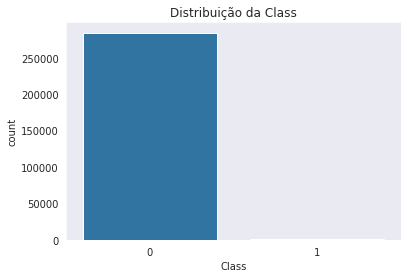

In [17]:
# Ver balanciamento dos dados
print(df.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset" .format((df[df.Class == 1].shape[0] / df.shape[0])*100))

# Plotar gráfico de barra para variável Classes
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição da Class')
plt.plot


Aplicamos a distribuição das 2 Classe ao longo do `Time`

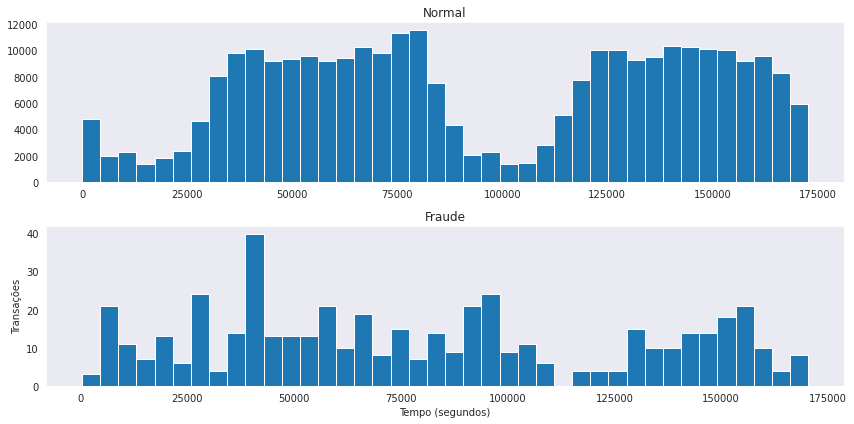

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class== 1], bins=num_bins)
ax[1].set_title('Fraude')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()